## Collaborative Filtering Algorithms with Community Detection

⚠️ This Jupyter notebook aims to conduct an experimental study to evaluate the performance of various collaborative filtering algorithms when combined with community detection techniques.
The algorithms will be evaluated based on RMSE, MSE and MAE metrics and the results will be saved in CSV file for further analysis.

### ⚙️ Environment settings

In [1]:
"""
    Importing needed libs
"""

'\n    Importing needed libs\n'

In [3]:
import os
import numpy as np
import pandas as pd
from typing import List
from surprise import (
    accuracy,
    Reader,
    Dataset,
    CoClustering,
    KNNBasic,
    NMF,
    SVD
)
from surprise.model_selection.split import ShuffleSplit
from surprise.trainset import Trainset
import networkx as nx
import cdlib.algorithms as cd_alg
import karateclub as kc
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [4]:
"""
    Setting up functions
"""

'\n    Setting up functions\n'

In [5]:
def uncouple(train_set: Trainset, test_set: list):
    """
    Description:
        It takes in a Trainset-Surprise object and 
        a list of test set data, and returns two pandas 
        dataframes: one containing the training set 
        data, and the other containing the test set 
        data.
    Input: 
        train_set: a Trainset object containing the 
        training set data. 
        test_set: a list containing the test set data
    Output:
        df_train: a pandas dataframe containing the 
        training set data, with columns 'uid', 'iid' 
        and 'rating'
        df_test: a pandas dataframe containing the test 
        set data, with columns 'uid', 'iid', and 'rating'
    """
    iterator = train_set.all_ratings()
    df_train = pd.DataFrame(train_set.all_ratings(), columns=['uid', 'iid', 'rating'])
    df_test = pd.DataFrame.from_records(test_set, columns = ['uid', 'iid', 'rating'])
    
    return df_train, df_test


def communitarian_recommendation_graph(
        n_user=100,
        n_comm=10,
        n_item=100,
        n_cat=10,
        like_prob=.4,
        like_strength=.5,
        debug=False,
    ):

    user_comm_gt = np.random.choice(n_comm, n_user)
    user_comm_gt.sort()
    bincount_user = np.bincount(user_comm_gt, minlength=n_comm)

    if debug:
        display('user', user_comm_gt, bincount_user)

    item_cat_gt = np.random.choice(n_cat, n_item)
    item_cat_gt.sort()
    bincount_item = np.bincount(item_cat_gt, minlength=n_cat)

    if debug:
        display('item', item_cat_gt, bincount_item)

    L = np.random.choice(2, (n_comm, n_cat), p=[1-like_prob, like_prob])

    L_prime = like_strength * L + (1-like_strength)/2

    P = np.block([
        [ np.zeros((n_comm,n_comm)) , L_prime                 ],
        [ L_prime.T                 , np.zeros((n_cat,n_cat)) ]
    ])

    if debug:
        display('like', L, L_prime, P)

    sbg = nx.stochastic_block_model(
        np.hstack((bincount_user, bincount_item)),
        P
    )

    if debug:
        try:
            nx.draw_networkx(
                sbg,
                nx.bipartite_layout(sbg, nx.bipartite.sets(sbg)[0]),
                node_color=np.hstack((user_comm_gt, item_cat_gt))
            )
        except nx.AmbiguousSolution as e:
            print(e)            

        plt.show()

    for user, item, data in sbg.edges(data=True):
        data['weight'] = np.random.randint(1,4) + 2*L[user_comm_gt[user], item_cat_gt[item-n_user]]

    if debug:
        display(np.mean([w['weight'] for user, item, w in sbg.edges(data=True) if L[user_comm_gt[min(user, item)], item_cat_gt[max(user, item)-n_user]]]))
        display(np.mean([w['weight'] for user, item, w in sbg.edges(data=True) if not L[user_comm_gt[min(user, item)], item_cat_gt[max(user, item)-n_user]]]))
        
    return sbg, user_comm_gt, item_cat_gt


def wf(G, u, v):
    w = 0    
    for nbr in set(G[u]) & set(G[v]):
        w += (G[u][nbr]['weight'] - G[v][nbr]['weight']) ** 2
    return 1/(1 + w)

In [6]:
"""
    Setting up experiment algorithms 
"""

'\n    Setting up experiment algorithms \n'

In [7]:
nx.__version__

'3.1'

In [8]:
algos_recommendation = {
    'SVD': SVD(verbose=False),
    'k-NN': KNNBasic(verbose=False), 
    'NMF': NMF(verbose=False), 
    'Co-Clustering': CoClustering(verbose=False)
}

communities_detectors = {
    'Not-Applicable': None,
    'Louvain': nx.community.louvain_communities,
    'Paris': cd_alg.paris,
    #'EdMot': kc.EdMot()
}

### 🖥️ Synthetic data generation

In [9]:
crg, user_comm_gt, item_cat_gt = communitarian_recommendation_graph(debug=False)
data = nx.to_pandas_edgelist(crg)
data.rename(columns={
        'source': 'uid',
        'target': 'iid',
        'weight': 'rating'
}, inplace=True)
data

,uid,iid,rating
0,0,100,3
1,0,107,1
2,0,110,3
3,0,115,3
4,0,116,2
...,...,...,...
4309,95,188,3
4310,95,190,3
4311,95,191,3
4312,95,197,3


In [10]:
pd.DataFrame({'# Users': [data['uid'].nunique()],
              '# Itens': [data['iid'].nunique()],
              '# Ratings': [data.shape[0]]
              }
             )

,# Users,# Itens,# Ratings
0,100,100,4314


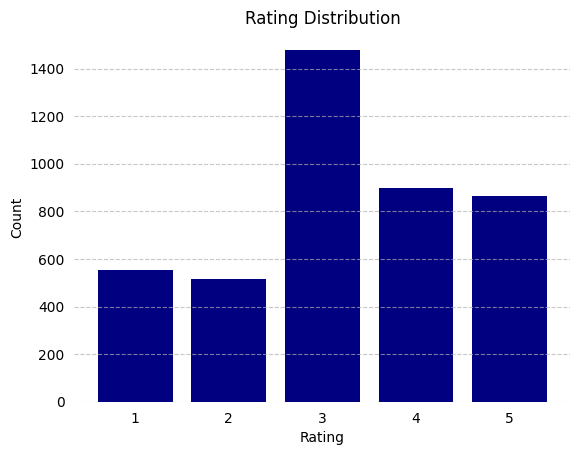

In [11]:
ax = data['rating'].value_counts().sort_index().plot(kind='bar', color='navy', width=0.8)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation='horizontal')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(left=False, bottom=False)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Running experiment

In [12]:
reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(
    data[["uid", "iid", "rating"]], reader
    )

print(type(dataset))
pd.DataFrame({'# Users': [len(set([user_id for (user_id, _, _, _) in dataset.raw_ratings]))],
              '# Itens': [len(set([item_id for (_, item_id, _, _) in dataset.raw_ratings]))],
              '# Ratings': [len(dataset.raw_ratings)]
              }
             )

<class 'surprise.dataset.DatasetAutoFolds'>


,# Users,# Itens,# Ratings
0,100,100,4314


In [13]:
results=[]
for test_size in tqdm([0.25, 0.1, 0.01], desc='📊 Test Size Progress', leave=True):
        shuffle_split = ShuffleSplit(n_splits=5, test_size=test_size)
        split_id = 1
        for trainset, testset in tqdm(shuffle_split.split(dataset), desc='➗ Splits Progress', leave=False):
            for detector_name, community_detector in tqdm(communities_detectors.items(), desc='🕸️ Community Detector Progress', leave=False):
                for algo_name, algo in  tqdm(algos_recommendation.items(), desc='👾 Algorithm Progress', leave=False):
                    if community_detector == None:
                        algo.fit(trainset)
                        predictions = algo.test(testset)
                        rmse_value = accuracy.rmse(predictions, verbose=False)
                        mse_value = accuracy.mse(predictions, verbose=False)
                        mae_value = accuracy.mae(predictions, verbose=False)
                        result_dict = {
                            'community_detector': detector_name,
                            'algorithm_rec': algo_name,
                            'test_size': test_size,
                            'split_id': split_id,
                            'rmse': rmse_value,
                            'mse': mse_value,
                            'mae': mae_value
                            }
                        results.append(result_dict)
                    else:
                        trainpd, testpd = uncouple(trainset, testset)
                        users_id = sorted(
                                list(
                                    set(
                                        trainpd['uid']
                                        )
                                    )
                                )
                        temp = trainpd.copy()
                        temp.rename(columns={
                            'uid': 'source',
                            'iid': 'target',
                            'rating': 'weight'
                        }, inplace=True)
                        crg = nx.from_pandas_edgelist(temp, source='source', target='target', edge_attr='weight')
                        g = nx.bipartite.generic_weighted_projected_graph(crg, 
                                                  users_id, wf
                                                  )
                        if detector_name == 'Louvain':
                            coms = community_detector(g.copy())
                        elif detector_name == 'EdMot':
                            community_detector.fit(g.copy())
                            coms = community_detector.get_memberships()
                        else:
                            coms = community_detector(g.copy()).communities
                        all_predictions = []
                        for community in tqdm(coms, desc='👤 Communities progress', leave=False):
                            train_community = trainpd[trainpd['uid'].isin(community)]
                            test_community = testpd[testpd['uid'].isin(community)]
                            train_surprise = Dataset.load_from_df(train_community[['uid', 'iid', 'rating']], reader)
                            train_surprise = train_surprise.build_full_trainset()
                            test_community = test_community.astype(
                                {'uid':'float', 'iid':'float', 'rating':'float'}
                                )
                            test_surprise = list(test_community.itertuples(index=False, name=None))
                            algo.fit(train_surprise)
                            predictions = algo.test(test_surprise) 
                            all_predictions.extend(predictions)
                        
                        rmse_value = accuracy.rmse(all_predictions, verbose=False)
                        mse_value = accuracy.mse(all_predictions, verbose=False)
                        mae_value = accuracy.mae(all_predictions, verbose=False)
                        result_dict = {
                                'community_detector': detector_name,
                                'algorithm_rec': algo_name,
                                'test_size': test_size,
                                'split_id': split_id,
                                'rmse': rmse_value,
                                'mse': mse_value,
                                'mae': mae_value
                            }
                        results.append(result_dict)                               
            split_id += 1
            
# -- Saving results in a .csv file
df_results = pd.DataFrame(results)
file_name = f'synt_results.csv'
notebook_dir = os.getcwd()
outputs_dir = notebook_dir.replace('notebooks', 'outputs')
file_path = os.path.join(outputs_dir, file_name)
df_results.to_csv(file_path, index=False)
            

📊 Test Size Progress:   0%|          | 0/3 [00:00<?, ?it/s]

➗ Splits Progress: 0it [00:00, ?it/s]

🕸️ Community Detector Progress:   0%|          | 0/3 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/5 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/5 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/16 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/16 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/16 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/16 [00:00<?, ?it/s]

🕸️ Community Detector Progress:   0%|          | 0/3 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/48 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/48 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/48 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/48 [00:00<?, ?it/s]

🕸️ Community Detector Progress:   0%|          | 0/3 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

🕸️ Community Detector Progress:   0%|          | 0/3 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/49 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/49 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/49 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/49 [00:00<?, ?it/s]

🕸️ Community Detector Progress:   0%|          | 0/3 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/5 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/5 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/8 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/8 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/8 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/8 [00:00<?, ?it/s]

➗ Splits Progress: 0it [00:00, ?it/s]

🕸️ Community Detector Progress:   0%|          | 0/3 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/2 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/2 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/2 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/2 [00:00<?, ?it/s]

🕸️ Community Detector Progress:   0%|          | 0/3 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/5 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/2 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/2 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/2 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/2 [00:00<?, ?it/s]

🕸️ Community Detector Progress:   0%|          | 0/3 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/24 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/24 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/24 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/24 [00:00<?, ?it/s]

🕸️ Community Detector Progress:   0%|          | 0/3 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

🕸️ Community Detector Progress:   0%|          | 0/3 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/39 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/39 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/39 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/39 [00:00<?, ?it/s]

➗ Splits Progress: 0it [00:00, ?it/s]

🕸️ Community Detector Progress:   0%|          | 0/3 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/5 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/5 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/5 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/5 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/5 [00:00<?, ?it/s]

🕸️ Community Detector Progress:   0%|          | 0/3 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

🕸️ Community Detector Progress:   0%|          | 0/3 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/20 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/20 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/20 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/20 [00:00<?, ?it/s]

🕸️ Community Detector Progress:   0%|          | 0/3 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/4 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/33 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/33 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/33 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/33 [00:00<?, ?it/s]

🕸️ Community Detector Progress:   0%|          | 0/3 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/3 [00:00<?, ?it/s]

👾 Algorithm Progress:   0%|          | 0/4 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/14 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/14 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/14 [00:00<?, ?it/s]

👤 Communities progress:   0%|          | 0/14 [00:00<?, ?it/s]

### Next Steps:
* Investigate if very small communities may be affecting performance.
* Investigate if the comparison is appropriate -- e.g., is it possible that there is someone in the test set without a community?
* Can a larger network lead to performance improvement?